In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import numpy as np

import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('gold_price_data (2).csv')
df

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [32]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


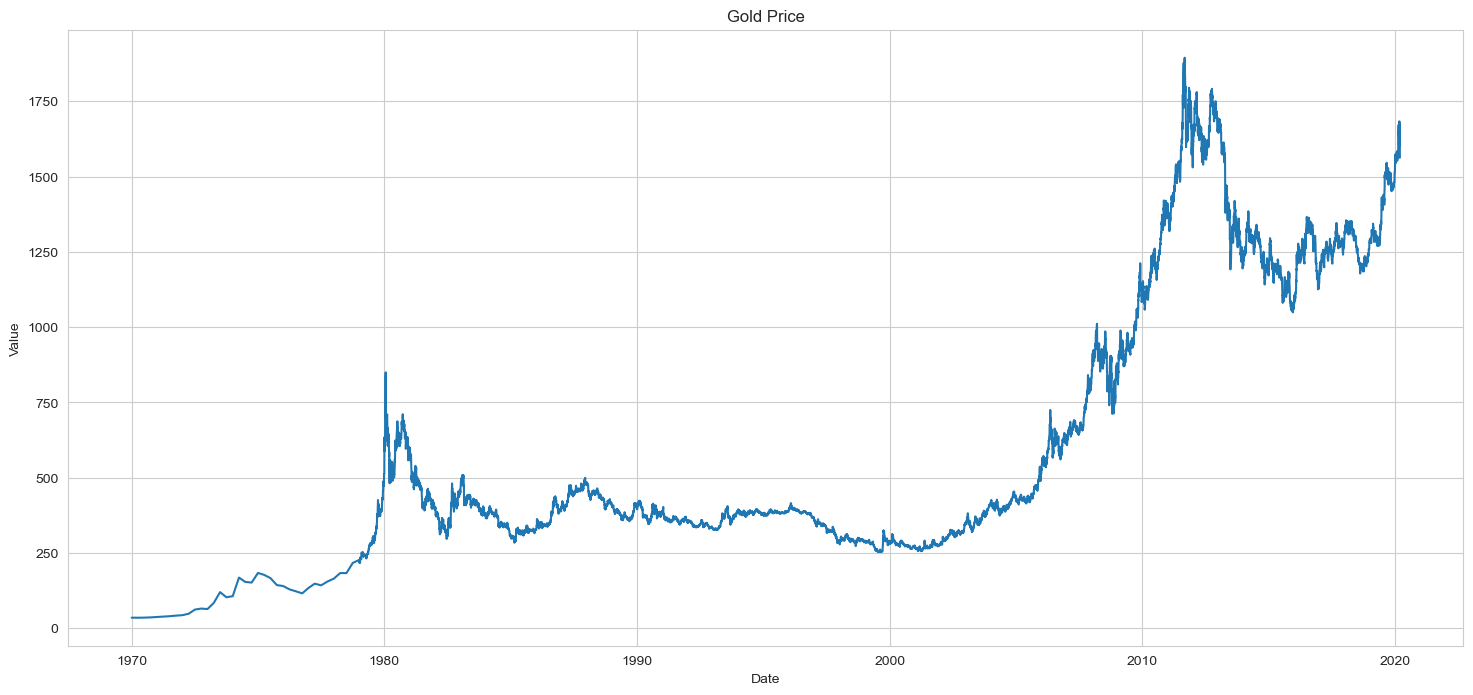

In [5]:
plt.figure(figsize = (18,8))
sns.lineplot(data=df, x="Date", y="Value")
plt.title('Gold Price')
plt.show()

In [6]:
gold_eda = df.copy()
gold_eda.set_index('Date', inplace=True)

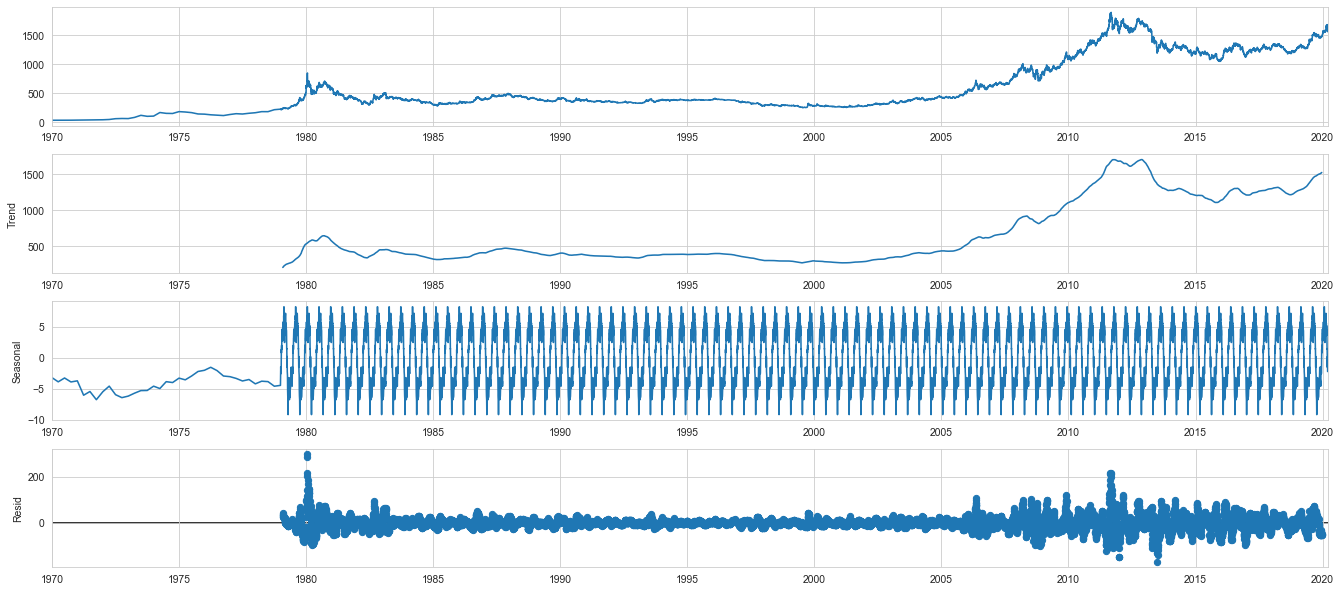

In [7]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_eda, model='additive', period=120)
result.plot()
plt.show()

In [8]:
X_train = df[:8090]
X_test = df[8090:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

X_train Shape (8090, 2)
X_test Shape (2697, 2)


In [9]:
X_train = X_train[['Date', 'Value']]
X_test = X_test[['Date', 'Value']]

X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)

In [10]:
index_9_months = pd.date_range(X_test.index[-1], freq='MS', periods=9)
index_9_months

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [11]:
def define_d(data):
    X_train = adfuller(data, autolag='AIC')
    adf = X_train[0]
    pvalue = X_train[1]
    critical_value = X_train[4]['5%']
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations', 'Critical Value']
    for value,label in zip(X_train,labels):
        print(label+' : '+str(value) )

    if (pvalue < 0.05):
        print("** Data Is Stationary **")
    else:
        print("** Indicating It Is Non-Stationary **")

define_d(X_train)

ADF Test Statistic : 0.7111393941300064
p-value : 0.9900575735401027
#Lags Used : 36
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Indicating It Is Non-Stationary **


In [12]:
data_diff = X_train.diff()
data_diff.dropna(inplace=True)
define_d(data_diff)

ADF Test Statistic : -15.695627256339892
p-value : 1.4163027798509658e-28
#Lags Used : 35
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Data Is Stationary **


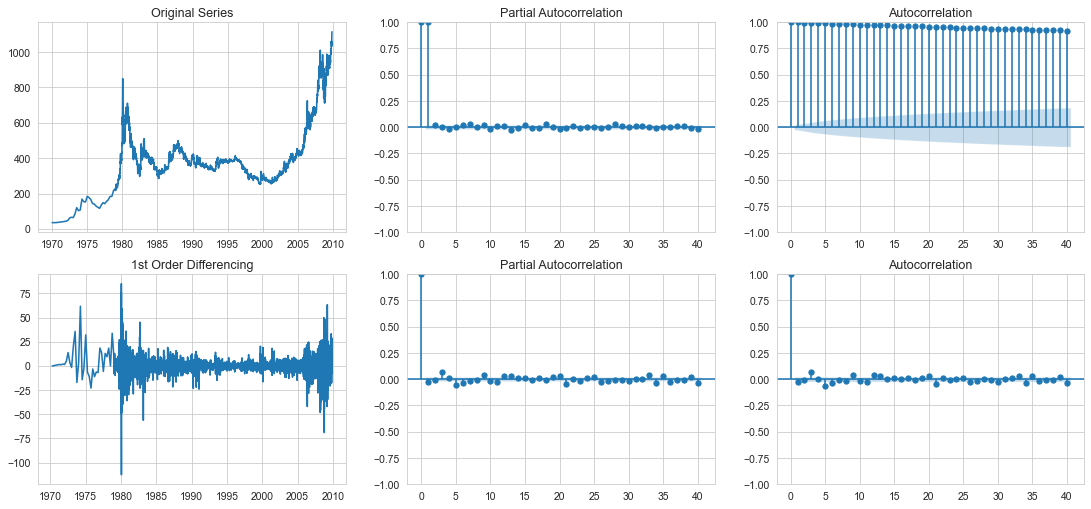

In [13]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(X_train); axes[0, 0].set_title('Original Series')
plot_pacf(X_train, ax=axes[0, 1])
plot_acf(X_train, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(X_train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(X_train.diff().dropna(), ax=axes[1, 1])
plot_acf(X_train.diff().dropna(), ax=axes[1, 2])

plt.show()

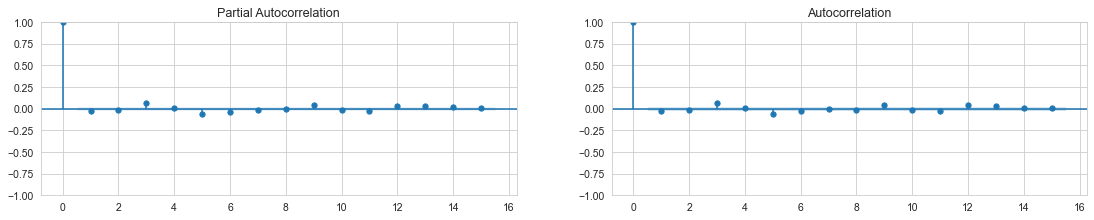

In [14]:
plt.rcParams.update({'figure.figsize':(18,3), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
plot_pacf(X_train.diff().dropna(), lags = 15, ax=ax[0])
plot_acf(X_train.diff().dropna(), lags = 15, ax=ax[1])
plt.show()

In [15]:
gold_validate = df['Value'][8090:]


In [21]:
model_gold = ARIMA(X_train, order = (0, 1, 0))
gold_010 = model_gold.fit()
print(gold_010.summary())

# Perform forecasting
forecast_results = gold_010.get_forecast(steps=2697)  # Returns a PredictionResults object

# Extract components
fc = forecast_results.predicted_mean  # Forecasted values
conf = forecast_results.conf_int(alpha=0.05)  # Confidence intervals

# Standard errors can be calculated if needed
se = (conf.iloc[:, 1] - conf.iloc[:, 0]) / 2

print(fc)  # Print forecasted values
print(conf)  # Print confidence intervals


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 8090
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -26956.059
Date:                Thu, 28 Nov 2024   AIC                          53914.118
Time:                        09:37:32   BIC                          53921.116
Sample:                             0   HQIC                         53916.512
                               - 8090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        45.9243      0.182    252.827      0.000      45.568      46.280
Ljung-Box (L1) (Q):                   5.93   Jarque-Bera (JB):            295889.08
Prob(Q):                              0.01   Pr

In [23]:
model_gold = ARIMA(X_train, order = (1, 1, 1))
gold_111 = model_gold.fit()
print(gold_111.summary())


# Perform forecasting
forecast_results = gold_111.get_forecast(steps=2697)  # Returns a PredictionResults object

# Extract components
fc = forecast_results.predicted_mean  # Forecasted values
conf = forecast_results.conf_int(alpha=0.05)  # Confidence intervals

# Standard errors can be calculated if needed
se = (conf.iloc[:, 1] - conf.iloc[:, 0]) / 2

print(fc)  # Print forecasted values
print(conf)  # Print confidence intervals


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 8090
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26956.059
Date:                Thu, 28 Nov 2024   AIC                          53918.117
Time:                        09:39:08   BIC                          53939.112
Sample:                             0   HQIC                         53925.300
                               - 8090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6063     10.279     -0.059      0.953     -20.752      19.540
ma.L1          0.6061     10.280      0.059      0.953     -19.543      20.755
sigma2        45.9082      0.192    239.180      0.0

In [24]:
model_gold = ARIMA(X_train, order = (1, 1, 0))
gold_110 = model_gold.fit()
print(gold_110.summary())


# Perform forecasting
forecast_results = gold_110.get_forecast(steps=2697)  # Returns a PredictionResults object

# Extract components
fc = forecast_results.predicted_mean  # Forecasted values
conf = forecast_results.conf_int(alpha=0.05)  # Confidence intervals

# Standard errors can be calculated if needed
se = (conf.iloc[:, 1] - conf.iloc[:, 0]) / 2

print(fc)  # Print forecasted values
print(conf)  # Print confidence intervals


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 8090
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -26953.176
Date:                Thu, 28 Nov 2024   AIC                          53910.352
Time:                        09:41:03   BIC                          53924.348
Sample:                             0   HQIC                         53915.140
                               - 8090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0267      0.004     -6.996      0.000      -0.034      -0.019
sigma2        45.8960      0.182    252.848      0.000      45.540      46.252
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [25]:
model_gold = ARIMA(X_train, order = (0, 1, 1))
gold_011 = model_gold.fit()
print(gold_011.summary())


# Perform forecasting
forecast_results = gold_011.get_forecast(steps=2697)  # Returns a PredictionResults object

# Extract components
fc = forecast_results.predicted_mean  # Forecasted values
conf = forecast_results.conf_int(alpha=0.05)  # Confidence intervals

# Standard errors can be calculated if needed
se = (conf.iloc[:, 1] - conf.iloc[:, 0]) / 2

print(fc)  # Print forecasted values
print(conf)  # Print confidence intervals


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 8090
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -26953.121
Date:                Thu, 28 Nov 2024   AIC                          53910.242
Time:                        09:42:16   BIC                          53924.239
Sample:                             0   HQIC                         53915.031
                               - 8090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0272      0.004     -7.172      0.000      -0.035      -0.020
sigma2        45.9130      0.182    252.695      0.000      45.557      46.269
Ljung-Box (L1) (Q):                   0.00   Jarque-

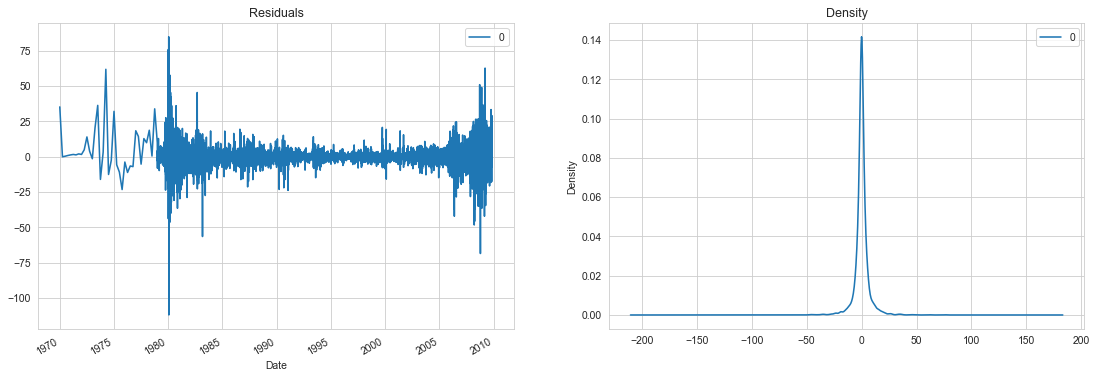

Text(0.5, 1.0, 'Comparison Forecast Test')

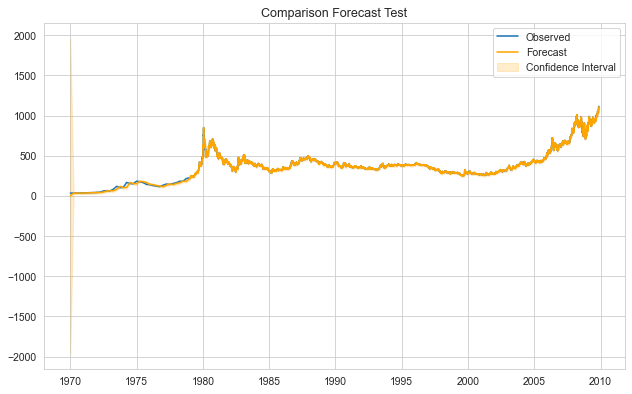

In [28]:
plt.rcParams.update({'figure.figsize':(18,6), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
residuals = pd.DataFrame(gold_011.resid)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

import matplotlib.pyplot as plt

# Generate predictions
pred = gold_011.get_prediction(dynamic=False)  # Adjust `dynamic` as needed

# Extract prediction mean and confidence intervals
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(X_train, label='Observed')

# Plot predictions
plt.plot(pred_mean, label='Forecast', color='orange')
plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],  # Lower bound
    pred_ci.iloc[:, 1],  # Upper bound
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)

plt.legend()
plt.title('Comparison Forecast Test', fontsize=12)
